<a href="https://colab.research.google.com/github/Adityarahul7575/Face-Emotion-Recognition-FER-/blob/main/fervgg16_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the libraries
import numpy as np
from scipy import ndimage, misc
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

**Unzipping the Data**

In [ ]:
!unzip '/content/drive/MyDrive/fer.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

**Counting the Expression datasets**

In [ ]:
train_dir = '../content/train/'
test_dir = '../content/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  happy  surprise   sad  disgust  fear  neutral
train   3995   7215      3171  4830      436  4097     4965
      angry  happy  surprise   sad  disgust  fear  neutral
test    958   1774       831  1247      111  1024     1233


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(train_dir, output="/content/fertrainval/", seed=1337, ratio=(.8,.2)) 

Copying files: 28709 files [00:13, 2075.81 files/s]


**Augmenting the disgust dataset to get more images**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')



In [ ]:
import cv2

In [ ]:
import numpy as np
from skimage import io
import os
from PIL import Image
try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3

image_directory = '/content/fertrainval/train/disgust/'
SIZE = 48
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + image_name)
        image = Image.fromarray(image, mode="RGB")
        image = image.resize((SIZE,SIZE))
        dataset.append(np.array(image))
       

x = np.array(dataset)

        

In [ ]:
i = 0
for batch in datagen.flow(x, batch_size=64,  
                          save_to_dir='/content/fertrainval/train/disgust/', 
                          save_prefix='aug', 
                          save_format='jpg'):
    i += 1
    if i > 63:
        break

In [ ]:
#counting the datasets
fertrain_dir = "/content/fertrainval/train/"
ferval_dir = "/content/fertrainval/val/"
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(fertrain_dir, 'train')
test_count = count_exp(ferval_dir, 'test')
print(train_count)
print(test_count)

       angry  happy  surprise   sad  disgust  fear  neutral
train   3196   5772      2536  3864     4083  3277     3972
      angry  happy  surprise  sad  disgust  fear  neutral
test    799   1443       635  966       88   820      993


**Creating the Data Generator for training,Validation,testing data**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
#training datagenerator
train_dataset  = train_datagen.flow_from_directory(directory = '/content/fertrainval/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 26700 images belonging to 7 classes.


In [ ]:
#validation datagenerator
valid_dataset = train_datagen.flow_from_directory(directory = '/content/fertrainval/val',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'training',
                                                  batch_size = 64)

Found 5744 images belonging to 7 classes.


In [ ]:
#test datagenerator. 
test_dataset = test_datagen.flow_from_directory(directory = '/content/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


**MODEL CREATION**

In [ ]:
#creating vgg16 model
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.7))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

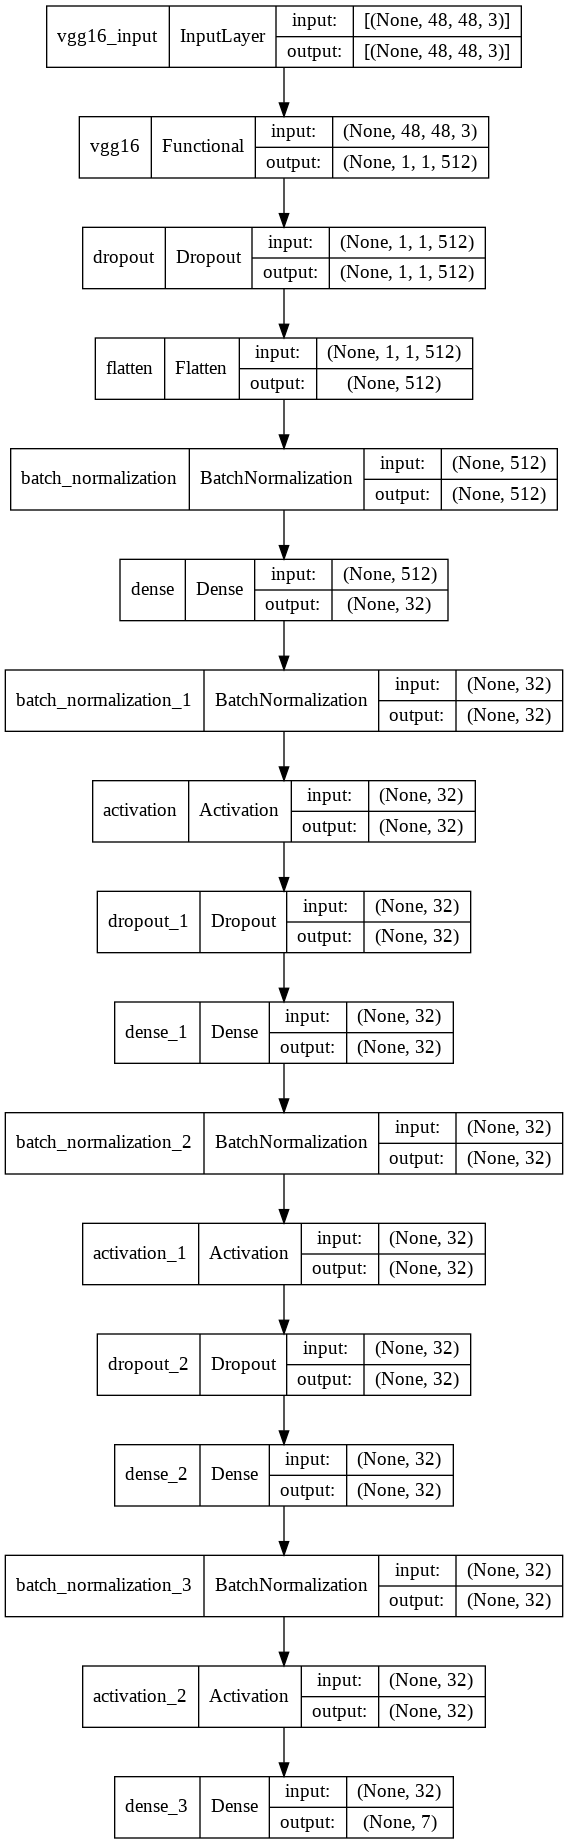

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
#getting the f1 score
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

**LOADING CHECKPOINTS**

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Face Emotions",
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True,
        save_weights_only=False)

**COMPILING THE MODEL**

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
#fitting the model
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 60,verbose = 1,callbacks = [checkpoint])

Epoch 1/60
418/418 [==============================] - ETA: 0s - loss: 2.0069 - accuracy: 0.8555 - precision: 0.1360 - recall: 0.0021 - auc: 0.5363 - f1_score: 0.0040
Epoch 00001: val_accuracy improved from -inf to 0.85714, saving model to /content/drive/MyDrive/Face Emotions
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Face Emotions/assets
418/418 [==============================] - 79s 159ms/step - loss: 2.0069 - accuracy: 0.8555 - precision: 0.1360 - recall: 0.0021 - auc: 0.5363 - f1_score: 0.0040 - val_loss: 1.9355 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5574 - val_f1_score: 0.0000e+00
Epoch 2/60
418/418 [==============================] - ETA: 0s - loss: 1.9413 - accuracy: 0.8571 - precision: 0.2759 - recall: 2.9963e-04 - auc: 0.5588 - f1_score: 5.8888e-04
Epoch 00002: val_accuracy did not improve from 0.85714
418/418 [==============================] - 57s 136ms/step - loss: 1.9413 - accuracy: 0.8571 - precision: 0.2759 - 

In [ ]:
model.save('/content/drive/MyDrive/Face Emotions/face.h5')

**PLOTS**

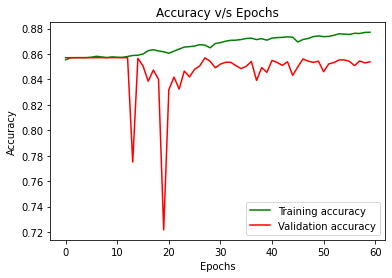

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val=  history.history['val_accuracy']
plt.plot( accuracy_train, 'g', label='Training accuracy')
plt.plot( accuracy_val, 'r', label='Validation accuracy')
plt.title('Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


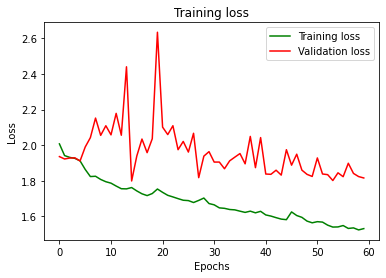

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot( loss_train, 'g', label = 'Training loss' )
plt.plot( loss_val, 'r', label = 'Validation loss' )
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset, verbose=1)

113/113 [==============================] - 7s 60ms/step - loss: 1.7455 - accuracy: 0.8578 - precision: 0.6667 - recall: 0.0092 - auc: 0.6986 - f1_score: 0.0177


[1.7454839944839478,
 0.8577993512153625,
 0.6666666865348816,
 0.009194761514663696,
 0.6986123919487,
 0.017687963321805]

In [ ]:
predictions = model.predict(test_dataset, verbose=1)

113/113 [==============================] - 5s 39ms/step


In [ ]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
cm = confusion_matrix(y_true=test_dataset.classes, y_pred=np.argmax(predictions, axis=1))

In [ ]:
  import itertools    
  def plot_confusion_matrix(cm, classes, normalize=False, title='Condusion Matrix', cmap=plt.cm.Blues):
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
      threshold = cm.max() / 2.

      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j], horizontalalignment="center", color='white' if cm[i,j] > threshold else "black")
        
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
   

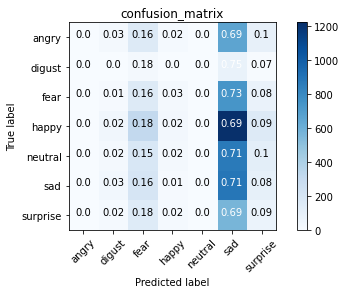

In [ ]:
cm_plot_labels = ['angry','digust','fear','happy','neutral','sad','surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

**Getting the accuracy of all training validation and testing datasets**

In [ ]:
train_loss, train_acc,train_precision,train_recall,train_auc,train_f1 = model.evaluate(train_dataset)
val_loss, val_acc,val_precision,val_recall,val_auc,val_f1   = model.evaluate(valid_dataset)
test_loss,test_acc,test_precision,test_recall,test_auc,test_f1 = model.evaluate(test_dataset)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f} ,testing accuracy ={:.2f}".format(train_acc*100, val_acc*100,test_acc*100))

113/113 [==============================] - 5s 45ms/step - loss: 1.7455 - accuracy: 0.8578 - precision: 0.6667 - recall: 0.0092 - auc: 0.6986 - f1_score: 0.0177
final train accuracy = 87.29 , validation accuracy = 85.36 ,testing accuracy =85.78
